[Big Data-4: Webserver log analysis with RDDs, Pyspark, SparkR and SparklyR](https://www.r-bloggers.com/2019/05/big-data-4-webserver-log-analysis-with-rdds-pyspark-sparkr-and-sparklyr/)

sample weblog is from https://opensource.indeedeng.io/imhotep/docs/sample-data/#nasa-apache-web-logs

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

from IPython.display import display, clear_output

spark = (SparkSession
    .builder
    .appName("weblog-analytics")
    .getOrCreate())

import os
SPARK_BOOK_DATA_PATH = os.environ['SPARK_BOOK_DATA_PATH']

In [2]:
SPARK_BOOK_DATA_PATH

'/home/wengong/spark_data/'

In [3]:
log_file = "19950801.00-19950901.00.tsv"  # specify csv file
log_file = "nasa_19950630.22-19950728.12.tsv.gz"   # specify compressed file
log_file = ""    # specify dir

logs_file_path=SPARK_BOOK_DATA_PATH + f"data/weblog/{log_file}"
logs_file_path

'/home/wengong/spark_data/data/weblog/'

In [4]:
base_df = (spark
           .read
           .option("header", "true")
           .option("sep", "\t")
           .option("inferSchema", "true")
           .csv(logs_file_path)
    )

In [5]:
base_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- logname: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- method: string (nullable = true)
 |-- url: string (nullable = true)
 |-- response: integer (nullable = true)
 |-- bytes: integer (nullable = true)
 |-- referer: string (nullable = true)
 |-- useragent: string (nullable = true)



In [6]:
base_df.count()
# 1891709   # 1 tsv file
# 3461595   # 2 compressed tsv files in one dir

3461595

In [7]:
display(base_df.limit(5).toPandas())

,host,logname,time,method,url,response,bytes,referer,useragent
0,199.72.81.55,-,804571201,GET,/history/apollo/,200,6245,None,None
1,unicomp6.unicomp.net,-,804571206,GET,/shuttle/countdown/,200,3985,None,None
2,199.120.110.21,-,804571209,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,4085,None,None
3,burger.letters.com,-,804571211,GET,/shuttle/countdown/liftoff.html,304,0,None,None
4,199.120.110.21,-,804571211,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,200,4179,None,None


In [8]:
spark.sql("select from_unixtime(807249608)").show()

+-------------------------------------------------------------+
|from_unixtime(CAST(807249608 AS BIGINT), yyyy-MM-dd HH:mm:ss)|
+-------------------------------------------------------------+
|                                          1995-08-01 00:00:08|
+-------------------------------------------------------------+



In [9]:
spark.sql("select unix_timestamp('2021-06-07 20:18:00')").show()   # 1623111473

+--------------------------------------------------------+
|unix_timestamp(2021-06-07 20:18:00, yyyy-MM-dd HH:mm:ss)|
+--------------------------------------------------------+
|                                              1623111480|
+--------------------------------------------------------+



In [10]:
split_df = base_df.selectExpr("host",
    "from_unixtime(time) as timestamp",
    "url as path",
    "response as status",
    "bytes as content_size")

In [11]:
split_df.show(3, truncate=False)

+--------------------+-------------------+--------------------------------------------+------+------------+
|host                |timestamp          |path                                        |status|content_size|
+--------------------+-------------------+--------------------------------------------+------+------------+
|199.72.81.55        |1995-07-01 00:00:01|/history/apollo/                            |200   |6245        |
|unicomp6.unicomp.net|1995-07-01 00:00:06|/shuttle/countdown/                         |200   |3985        |
|199.120.110.21      |1995-07-01 00:00:09|/shuttle/missions/sts-73/mission-sts-73.html|200   |4085        |
+--------------------+-------------------+--------------------------------------------+------+------------+
only showing top 3 rows



In [12]:
split_df.count()

3461595

In [13]:
cleaned_df = split_df.dropna(how="any")

In [14]:
cleaned_df.count()

3461595

##2.2 Check data

##2.3Check no of rows which do not have digits
We have already seen that the content_type field has '-' instead of digits in RDDs

##2.4 Add '*' to identify bad rows
To identify the rows that are bad, concatenate '*' to the content_size field where the field does not have digits. It can be seen that the content_size has '-' instead of a valid number

##2.5 Fill NAs with 0s

## 2.6 Compute counts of hosts

In [15]:
df= (cleaned_df
     .groupBy('host')
     .count()
     .orderBy('count',ascending=False))
df.show(5)

+--------------------+-----+
|                host|count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|  edams.ksc.nasa.gov|11964|
|        163.206.89.4| 9697|
+--------------------+-----+
only showing top 5 rows



##2.7 Plot count of hosts

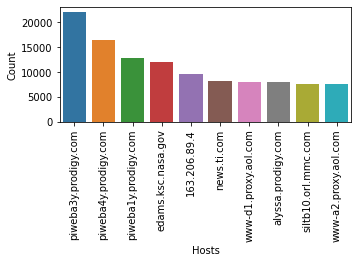

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df1=df.toPandas()
df2 = df1.head(10)
df2.count()
sns.barplot(x='host',y='count',data=df2)
# sns.barplot(orient='h', data=df2)
plt.subplots_adjust(bottom=0.5, right=0.8, top=0.9)
plt.xlabel("Hosts")
plt.ylabel('Count')
plt.xticks(rotation="vertical",fontsize=10)
display()

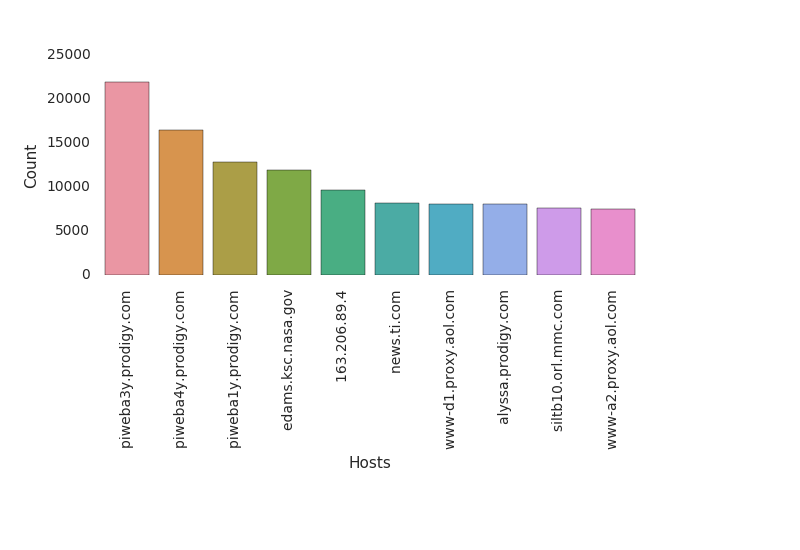

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df1=df.toPandas()
df2 = df1.head(10)
df2.count()
sns.barplot(x='host',y='count',data=df2)
plt.subplots_adjust(bottom=0.5, right=0.8, top=0.9)
plt.xlabel("Hosts")
plt.ylabel('Count')
plt.xticks(rotation="vertical",fontsize=10)
display()

##2.8 Compute count of HTTP requests

In [32]:
df= (cleaned_df
     .groupBy('path')
     .count()
     .orderBy('count',ascending=False))
df.show(5)

+--------------------+-----+
|                path|count|
+--------------------+-----+
|/images/NASA-logo...|97410|
|/images/KSC-logos...|75337|
|/images/MOSAIC-lo...|67448|
|/images/USA-logos...|67068|
|/images/WORLD-log...|66444|
+--------------------+-----+
only showing top 5 rows



##2.9 Plot count of HTTP Requests

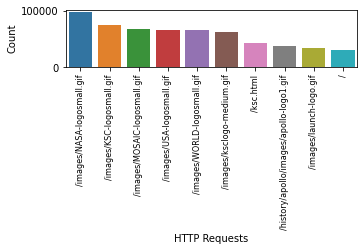

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df1=df.toPandas()
df2 = df1.head(10)
df2.count()
sns.barplot(x='path',y='count',data=df2)
plt.subplots_adjust(bottom=0.7, right=0.8, top=0.9)
plt.xlabel("HTTP Requests")
plt.ylabel('Count')
plt.xticks(rotation=90,fontsize=8)
display()

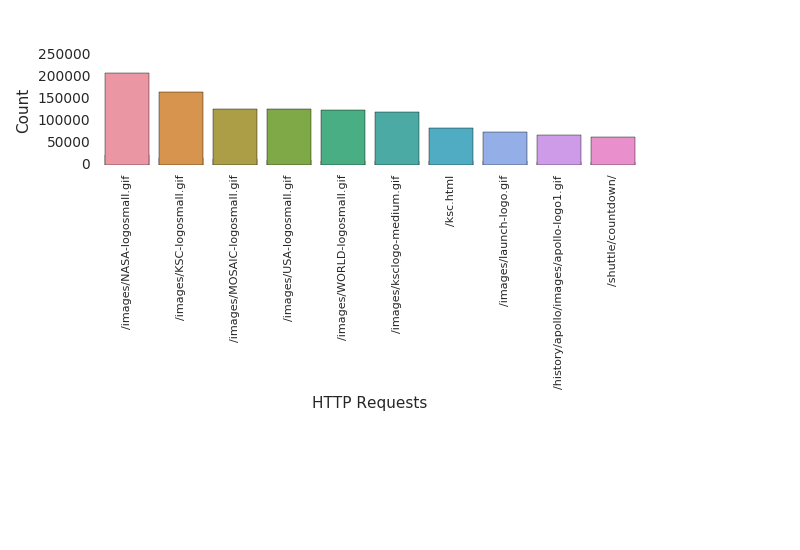

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df1=df.toPandas()
df2 = df1.head(10)
df2.count()
sns.barplot(x='path',y='count',data=df2)
plt.subplots_adjust(bottom=0.7, right=0.8, top=0.9)
plt.xlabel("HTTP Requests")
plt.ylabel('Count')
plt.xticks(rotation=90,fontsize=8)
display()

##2.11 Compute count of HTTP status

In [34]:
status_count=(cleaned_df
                .groupBy('status')
                .count()
                .orderBy('count',ascending=False))
status_count.show()

+------+-------+
|status|  count|
+------+-------+
|   200|1398987|
|   304| 134146|
|   302|  26497|
|   404|  10055|
|   403|    171|
|   501|     27|
|   500|      3|
+------+-------+



##2.12 Plot count of HTTP status
Plot the HTTP return status vs the counts

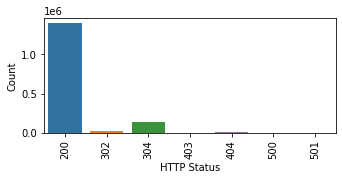

In [35]:
df1=status_count.toPandas()
df2 = df1.head(10)
df2.count()
sns.barplot(x='status',y='count',data=df2)
plt.subplots_adjust(bottom=0.5, right=0.8, top=0.9)
plt.xlabel("HTTP Status")
plt.ylabel('Count')
plt.xticks(rotation="vertical",fontsize=10)
display()


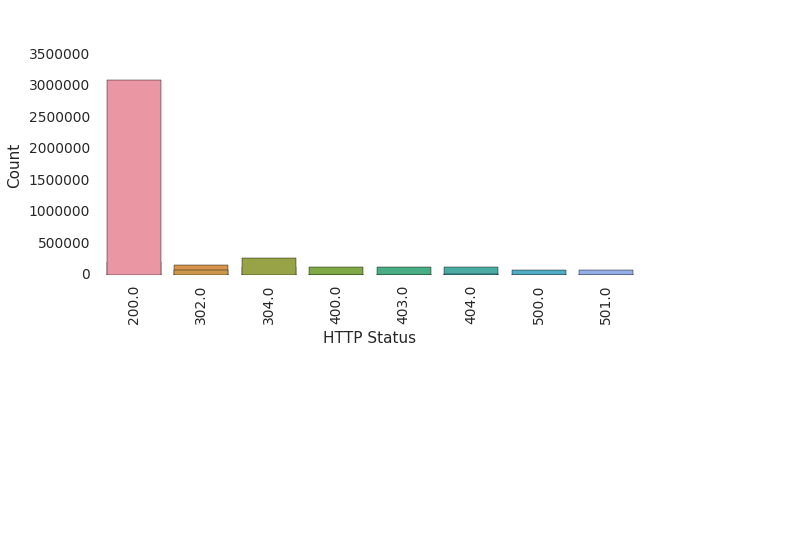

In [22]:
df1=status_count.toPandas()
df2 = df1.head(10)
df2.count()
sns.barplot(x='status',y='count',data=df2)
plt.subplots_adjust(bottom=0.5, right=0.8, top=0.9)
plt.xlabel("HTTP Status")
plt.ylabel('Count')
plt.xticks(rotation="vertical",fontsize=10)
display()


##2.13 Compute count of content_size

In [36]:
size_counts=(cleaned_df
                .groupBy('content_size')
                .count()
                .orderBy('count',ascending=False))
size_counts.show(10)


+------------+------+
|content_size| count|
+------------+------+
|           0|154577|
|         786| 77836|
|        1204| 63754|
|         363| 58392|
|         234| 58056|
|         669| 57641|
|        5866| 54656|
|        1173| 34396|
|        1713| 30824|
|        7131| 29104|
+------------+------+
only showing top 10 rows



##2.14 Plot counts of content size
Plot the path access versus the counts

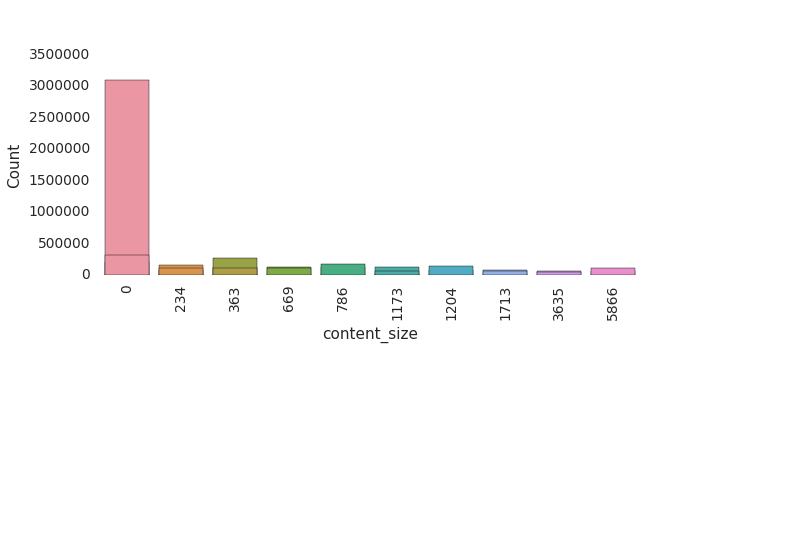

In [26]:
df1=size_counts.toPandas()
df2 = df1.head(10)
df2.count()
sns.barplot(x='content_size',y='count',data=df2)
plt.subplots_adjust(bottom=0.5, right=0.8, top=0.9)
plt.xlabel("content_size")
plt.ylabel('Count')
plt.xticks(rotation="vertical",fontsize=10)
display()

In [37]:
spark.stop()